In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

# Use GPU if available
device_name = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print("✅ Using:", device_name)

IMG_SIZE = 128
BATCH_SIZE = 32
MAX_TOKENS = 20  # short captions
EPOCHS = 10


✅ Using: GPU


In [12]:
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Define source (your uploaded file) and target paths
zip_path = "/content/drive/MyDrive/archive.zip"
extract_dir = "/content/animals10"

# Unzip into Colab
if os.path.exists(zip_path):
    print("✅ Found archive.zip in Drive. Extracting...")
    !mkdir -p /content/animals10
    !unzip -q "$zip_path" -d "$extract_dir"
    print("✅ Extraction complete.")
else:
    print("❌ archive.zip not found in your Drive. Please check path or rename file.")

# Verify structure
print("\n📁 Extracted dataset preview:")
!ls -R /content/animals10 | head -40


Mounted at /content/drive
✅ Found archive.zip in Drive. Extracting...
✅ Extraction complete.

📁 Extracted dataset preview:
/content/animals10:
raw-img
translate.py

/content/animals10/raw-img:
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo

/content/animals10/raw-img/cane:
OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg
OIP-00zvckpZ8XDEzk-Fv4HjkQHaGL.jpeg
OIP-0261T_DaSKSIDaRxrLjL8gHaGD.jpeg
OIP-02OsWT9t46zXPceBxMicNQAAAA.jpeg
OIP-036LqzhKXwF9eUWycl2V_QHaFt.jpeg
OIP-06txpJjbByyhAlbGkpSimAHaE8.jpeg
OIP-08Xf8bQxZmCDI_CozSO-YgHaH1.jpeg
OIP-0977rkGtQ_PPflLXiMRRYAHaFM.jpeg
OIP-09znoxk9htqGbe5yWTj1TAHaHa.jpeg
OIP-0a0_6W9xqdTrLnXcL8haUgHaLH.jpeg
OIP-0aPTy5pR8zwqdi5jabdxjwHaGL.jpeg
OIP-0B2H2VPu9neVWW7TtvJlPAAAAA.jpeg
OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg
OIP-0cKVI1PLYxC2MlqoYwMw4gHaHa.jpeg
OIP-0CmAiR3-B-VLurayKj2mwAHaE8.jpeg
OIP-0cMunZ5IpSFGRbH_vYFvXgHaJ3.jpeg
OIP-0cwqK_pId75Pu0YLQq7HwgHaKj.jpeg
OIP-0cYdzGqi1lvZQkk0Hy0GGAHaIu.jpeg
OIP--0CZnfLuBERVtzRm2QbB3gHaK4.jpeg
OIP-0d7hpjwVocPjQX

In [13]:
data_dir = "/content/animals10/raw-img"


In [14]:
pip install -q diffusers transformers accelerate datasets


In [ ]:
# --- Diffusion Model (DDPM) Training on Animals10 Dataset ---
# 64×64 VERSION (≈1–1.5 min per epoch on T4 GPU)
# ------------------------------------------------------------
import os, torch, random
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

data_root = "/content/animals10/raw-img"
out_dir = "/content/ddpm_outputs_64"
ckpt_dir = os.path.join(out_dir, "checkpoints")
os.makedirs(out_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 100           # updated
LR = 2e-4
NUM_TIMESTEPS = 1000
SAVE_EVERY = 10

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset = datasets.ImageFolder(root=data_root, transform=tfm)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Images:", len(dataset))

unet = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)

opt = optim.Adam(unet.parameters(), lr=LR)
mse = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

for epoch in range(1, EPOCHS + 1):
    unet.train()
    running_loss = 0.0

    for imgs, _ in tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        imgs = imgs.to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (imgs.size(0),), device=device).long()
        noise = torch.randn_like(imgs)
        noisy_imgs = noise_scheduler.add_noise(imgs, noise, timesteps)

        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            pred = unet(noisy_imgs, timesteps).sample
            loss = mse(pred, noise)

        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    print(f"[DDPM] Epoch {epoch}/{EPOCHS}  Loss: {avg_loss:.6f}")

    if epoch % SAVE_EVERY == 0 or epoch == 1 or epoch == EPOCHS:
        ckpt_path = os.path.join(ckpt_dir, f"unet_epoch_{epoch}.pt")
        torch.save(unet.state_dict(), ckpt_path)
        print("Saved checkpoint:", ckpt_path)

        unet.eval()
        pipe = DDPMPipeline(unet=unet, scheduler=noise_scheduler).to(device)

        with torch.no_grad():
            samples = pipe(num_inference_steps=50, batch_size=8).images
            for i, img in enumerate(samples):
                img.save(os.path.join(out_dir, f"sample_epoch{epoch}_{i}.png"))
        print(f"Saved sample images for epoch {epoch}\n")

print("Training Complete")
print("Results saved in:", out_dir)


Device: cuda
Images: 26179


/tmp/ipython-input-4055482852.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
Epoch 1/100:   0%|          | 0/819 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-4055482852.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):
                                                              

[DDPM] Epoch 1/100  Loss: 0.054887
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_1.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 1



[DDPM] Epoch 2/100  Loss: 0.031864


[DDPM] Epoch 3/100  Loss: 0.030185


[DDPM] Epoch 4/100  Loss: 0.028755


[DDPM] Epoch 5/100  Loss: 0.028370


[DDPM] Epoch 6/100  Loss: 0.027881


[DDPM] Epoch 7/100  Loss: 0.027276


[DDPM] Epoch 8/100  Loss: 0.027502


[DDPM] Epoch 9/100  Loss: 0.027146


[DDPM] Epoch 10/100  Loss: 0.026741
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_10.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 10



[DDPM] Epoch 11/100  Loss: 0.027590


[DDPM] Epoch 12/100  Loss: 0.027266


[DDPM] Epoch 13/100  Loss: 0.027022


[DDPM] Epoch 14/100  Loss: 0.026460


[DDPM] Epoch 15/100  Loss: 0.027251


[DDPM] Epoch 16/100  Loss: 0.025982


[DDPM] Epoch 17/100  Loss: 0.026736


[DDPM] Epoch 18/100  Loss: 0.025696


[DDPM] Epoch 19/100  Loss: 0.025584


[DDPM] Epoch 20/100  Loss: 0.025382
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_20.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 20



[DDPM] Epoch 21/100  Loss: 0.026135


[DDPM] Epoch 22/100  Loss: 0.026378


[DDPM] Epoch 23/100  Loss: 0.026305


[DDPM] Epoch 24/100  Loss: 0.025615


[DDPM] Epoch 25/100  Loss: 0.025203


[DDPM] Epoch 26/100  Loss: 0.025711


[DDPM] Epoch 27/100  Loss: 0.025470


[DDPM] Epoch 28/100  Loss: 0.025568


[DDPM] Epoch 29/100  Loss: 0.025678


[DDPM] Epoch 30/100  Loss: 0.025616
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_30.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 30



[DDPM] Epoch 31/100  Loss: 0.025558


[DDPM] Epoch 32/100  Loss: 0.025477


[DDPM] Epoch 33/100  Loss: 0.024669


[DDPM] Epoch 34/100  Loss: 0.025659


[DDPM] Epoch 35/100  Loss: 0.026014


[DDPM] Epoch 36/100  Loss: 0.025311


[DDPM] Epoch 37/100  Loss: 0.026073


[DDPM] Epoch 38/100  Loss: 0.024775


[DDPM] Epoch 39/100  Loss: 0.025288


[DDPM] Epoch 40/100  Loss: 0.025418
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_40.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 40



[DDPM] Epoch 41/100  Loss: 0.024875


[DDPM] Epoch 42/100  Loss: 0.024700


[DDPM] Epoch 43/100  Loss: 0.025097


[DDPM] Epoch 44/100  Loss: 0.024580


[DDPM] Epoch 45/100  Loss: 0.026002


[DDPM] Epoch 46/100  Loss: 0.025326


[DDPM] Epoch 47/100  Loss: 0.024709


[DDPM] Epoch 48/100  Loss: 0.024944


[DDPM] Epoch 49/100  Loss: 0.025574


[DDPM] Epoch 50/100  Loss: 0.025146
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_50.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 50



[DDPM] Epoch 51/100  Loss: 0.024963


[DDPM] Epoch 52/100  Loss: 0.025070


[DDPM] Epoch 53/100  Loss: 0.025068


[DDPM] Epoch 54/100  Loss: 0.025159


[DDPM] Epoch 55/100  Loss: 0.024981


[DDPM] Epoch 56/100  Loss: 0.025025


[DDPM] Epoch 57/100  Loss: 0.025531


[DDPM] Epoch 58/100  Loss: 0.025046


[DDPM] Epoch 59/100  Loss: 0.025073


[DDPM] Epoch 60/100  Loss: 0.025223
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_60.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 60



[DDPM] Epoch 61/100  Loss: 0.024954


[DDPM] Epoch 62/100  Loss: 0.024781


[DDPM] Epoch 63/100  Loss: 0.025277


[DDPM] Epoch 64/100  Loss: 0.025222


[DDPM] Epoch 65/100  Loss: 0.024832


[DDPM] Epoch 66/100  Loss: 0.025192


[DDPM] Epoch 67/100  Loss: 0.025165


[DDPM] Epoch 68/100  Loss: 0.025203


[DDPM] Epoch 69/100  Loss: 0.024757


[DDPM] Epoch 70/100  Loss: 0.025056
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_70.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 70



[DDPM] Epoch 71/100  Loss: 0.024936


[DDPM] Epoch 72/100  Loss: 0.024845


[DDPM] Epoch 73/100  Loss: 0.024884


[DDPM] Epoch 74/100  Loss: 0.025162


[DDPM] Epoch 75/100  Loss: 0.025481


[DDPM] Epoch 76/100  Loss: 0.024810


[DDPM] Epoch 77/100  Loss: 0.024396


[DDPM] Epoch 78/100  Loss: 0.025371


[DDPM] Epoch 79/100  Loss: 0.025428


[DDPM] Epoch 80/100  Loss: 0.025093
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_80.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 80



[DDPM] Epoch 81/100  Loss: 0.024802


[DDPM] Epoch 82/100  Loss: 0.024529


[DDPM] Epoch 83/100  Loss: 0.024758


[DDPM] Epoch 84/100  Loss: 0.024417


[DDPM] Epoch 85/100  Loss: 0.024991


[DDPM] Epoch 86/100  Loss: 0.024960


[DDPM] Epoch 87/100  Loss: 0.025127


[DDPM] Epoch 88/100  Loss: 0.025370


[DDPM] Epoch 89/100  Loss: 0.024698


[DDPM] Epoch 90/100  Loss: 0.024710
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_90.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 90



[DDPM] Epoch 91/100  Loss: 0.025074


[DDPM] Epoch 92/100  Loss: 0.025005


[DDPM] Epoch 93/100  Loss: 0.025315


[DDPM] Epoch 94/100  Loss: 0.024812


[DDPM] Epoch 95/100  Loss: 0.024851


[DDPM] Epoch 96/100  Loss: 0.024904


[DDPM] Epoch 97/100  Loss: 0.025138


[DDPM] Epoch 98/100  Loss: 0.024770


[DDPM] Epoch 99/100  Loss: 0.024125


[DDPM] Epoch 100/100  Loss: 0.024604
Saved checkpoint: /content/ddpm_outputs_64/checkpoints/unet_epoch_100.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Saved sample images for epoch 100

Training Complete
Results saved in: /content/ddpm_outputs_64


In [ ]:
# --- DDPM Model Testing (64×64) ---
import torch
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

ckpt = "/content/ddpm_outputs_64/checkpoints/unet_epoch_100.pt"

IMG_SIZE = 64
NUM_TIMESTEPS = 1000

unet = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
).to(device)

unet.load_state_dict(torch.load(ckpt, map_location=device))
unet.eval()

scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)

pipe = DDPMPipeline(unet=unet, scheduler=scheduler).to(device)

samples = pipe(num_inference_steps=50, batch_size=8).images

out_dir = "/content/ddpm_test_samples"
import os
os.makedirs(out_dir, exist_ok=True)

for i, img in enumerate(samples):
    img.save(f"{out_dir}/test_{i}.png")

print("done:", out_dir)


  0%|          | 0/50 [00:00<?, ?it/s]

done: /content/ddpm_test_samples


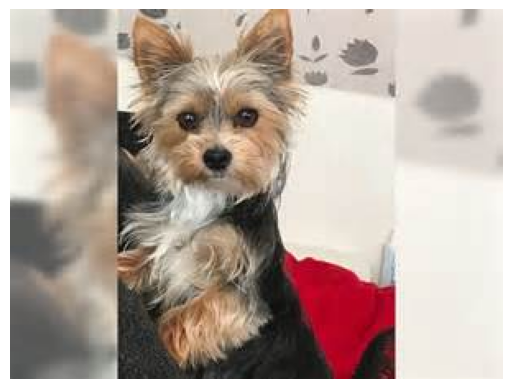

In [20]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

IMG = 64   # keep original resolution

tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder("/content/animals10/raw-img", transform=tfm)

img, _ = dataset[0]
img = img * 0.5 + 0.5     # unnormalize

plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.show()


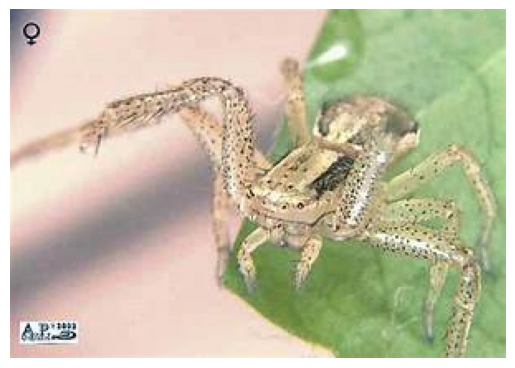

Original size: (300, 211)


In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

p = glob.glob("/content/animals10/raw-img/*/*")[0]

img = Image.open(p).convert("RGB")  # no resize
plt.imshow(img)
plt.axis("off")
plt.show()

print("Original size:", img.size)


In [2]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.3 MB/s eta 0:00:00


MSE: 0.5820090174674988
PSNR: 2.350703001022339
SSIM: 0.0014249016530811787
Perceptual Distance: 12.491806030273438


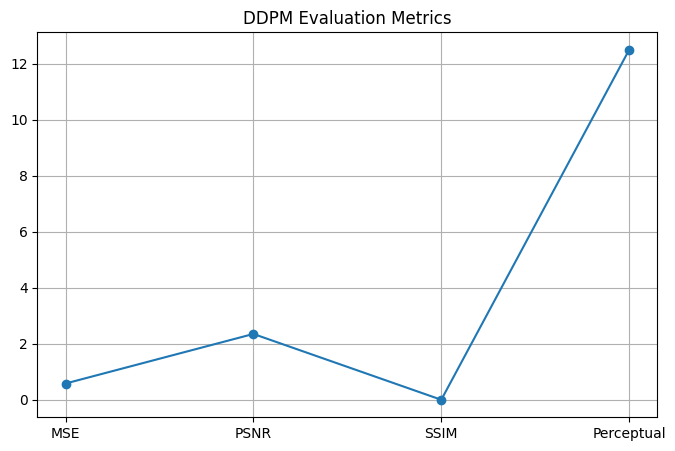

In [16]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt

device = "cuda"
img_size = 64
ckpt_path = "/content/diffusion_final.pt"
data_root = "/content/animals10/raw-img"

tfm = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# load real
ds = datasets.ImageFolder(root=data_root, transform=tfm)
real_loader = torch.utils.data.DataLoader(ds, batch_size=20, shuffle=True)
real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(device)

# unet
unet = UNet2DModel(
    sample_size=img_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

unet.load_state_dict(torch.load(ckpt_path, map_location=device))
unet.eval()

scheduler = DDPMScheduler(num_train_timesteps=1000)

# perceptual backbone
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16].to(device)
vgg.eval()

def gen(n=20):
    out = []
    for _ in range(n):
        x = torch.randn(1, 3, img_size, img_size, device=device)
        for t in reversed(range(1000)):
            with torch.no_grad():
                pred = unet(x, t).sample
            x = scheduler.step(pred, t, x).prev_sample
        out.append(x)
    return torch.cat(out)

def get_feat(x):
    return vgg(x)

def ssim(a, b):
    C1 = 0.01**2
    C2 = 0.03**2
    mu_a = a.mean()
    mu_b = b.mean()
    sigma_a = a.var()
    sigma_b = b.var()
    sigma_ab = ((a - mu_a) * (b - mu_b)).mean()
    return ((2*mu_a*mu_b + C1)*(2*sigma_ab + C2)) / ((mu_a**2 + mu_b**2 + C1)*(sigma_a + sigma_b + C2))

def psnr(a, b):
    mse = F.mse_loss(a, b)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# generate fake images
fake = gen(20)

# compute metrics
mse_val = F.mse_loss(fake, real_imgs).item()
psnr_val = psnr(fake, real_imgs).item()
ssim_val = ssim(fake, real_imgs).item()
lpips_val = F.mse_loss(get_feat(fake), get_feat(real_imgs)).item()

print("MSE:", mse_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("Perceptual Distance:", lpips_val)

# graph
names = ["MSE", "PSNR", "SSIM", "Perceptual"]
vals = [mse_val, psnr_val, ssim_val, lpips_val]

plt.figure(figsize=(8,5))
plt.plot(names, vals, marker="o")
plt.title("DDPM Evaluation Metrics")
plt.grid(True)
plt.show()


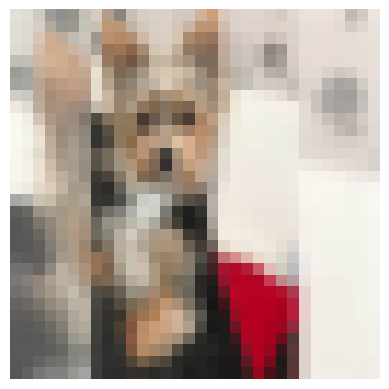

In [ ]:
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

IMG = 32

tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder("/content/animals10/raw-img", transform=tfm)

# show one real image (unnormalized)
img, _ = dataset[0]
img = img * 0.5 + 0.5   # undo normalization
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.show()
